# Core Task 1:

* Write first order equations of motion
*Explore undamped, undriven oscillations
*Investigate energy conservation
*Investigate how amplitude affects period


In [1]:
#importing necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate

In [2]:
t_0=2*np.pi #Natural period
g=9.81 #Acceleration due to gravity (also equal to length of pendulum)




def derivatives(t,y,q,F):
  '''
  Returns the derivatives for the pendulum motion
  q and F can be varied
  y[0]=theta, y[1]=d(theta)/dt
  '''
  return [y[1],-np.sin(y[0])-q*y[1]+F*np.sin(2/3*t)]

'''Use solve_ivp to numerically integrate for theta and d(theta)/dt
  Give the option to vary how long the integration runs for (t_span)
  Allow q,F and theta0 to be varied
  '''


q,F= (0,0) #undamped and undriven oscillations

theta_0= 0.01

t_span= (0,10*t_0)


test_solution=scipy.integrate.solve_ivp(
    fun=derivatives,
    t_span=t_span,
    y0=[theta_0,0],
    args=(q,F)
)



t,theta,w = test_solution.t, test_solution.y[0], test_solution.y[1]


def undamped_theory(t,theta0):
  ''' Theoretical result for undamped undriven oscillator with natural frequency 2*pi and using small angle approx.
  Increased the density of t values to make clear where the solve_ivp result varies from the expected value due to finite timesteps in the integration
  '''
  t_theory=np.linspace(t[0],t[-1],len(t)*10)
  return (t_theory, theta_0*np.cos(t_theory))

theta_theory=undamped_theory(t,theta_0)


### Testing initial code

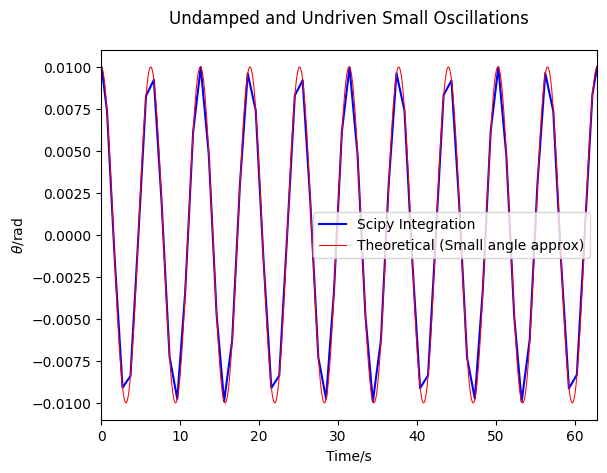

In [3]:
#Plot results
fig1,ax1 =plt.subplots()
ax1.set_xlabel('Time/s')
ax1.set_ylabel(r'$\theta$/rad')
ax1.set_title('Undamped and Undriven Small Oscillations', y=1.05)
ax1.set_xlim(t_span)
ax1.plot(t,theta,label='Scipy Integration',color='b')
ax1.plot(theta_theory[0],theta_theory[1],label='Theoretical (Small angle approx)',color='r',linestyle='-',linewidth=0.75)
ax1.legend(loc='best')

fig1.show()


### Assessing Energy Conservation

In [4]:
'''Plotting evolution of energy with time, E total is KE plus GPE (GPE taken to be 0 at theta=0)
  Choose unit mass m=1'''

t_0=2*np.pi #Natural period

q,F= (0,0) #undamped and undriven oscillations

theta_0= 0.01

t_span= (0,10000*t_0) #Analyse for 10,000 natural periods

solution1=scipy.integrate.solve_ivp(
    fun=derivatives,
    t_span=t_span,
    y0=[theta_0,0],
    args=(q,F)
)



t,theta,w = solution1.t, solution1.y[0], solution1.y[1]

#Function to return total energy at different times

def calc_energy(theta,w):
  KE=1/2*(g**2)*(w**2)
  GPE=(g**2)*(1-np.cos(theta))

  return KE+GPE

E=calc_energy(theta,w)

''' Initial energy is all GPE: g**2(1-cos(theta0)), this energy should be conserved for all t'''

E_theory=np.full_like(t,(g**2*(1-np.cos(theta_0))))

-8.781% energy change over 10000.0 periods of oscillation


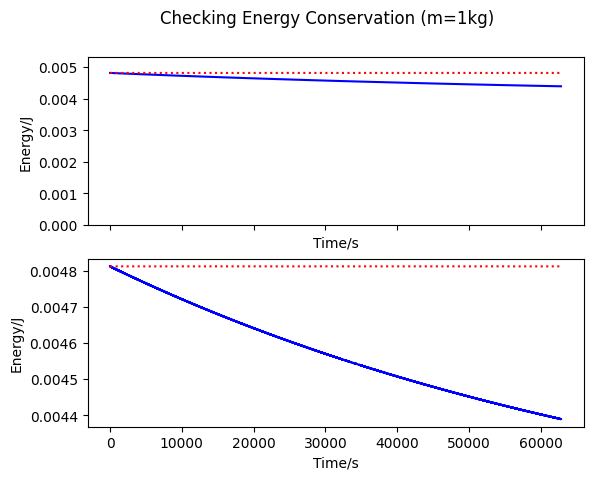

In [5]:
#Plot results
fig2, axs2 =plt.subplots(2,sharex= True)
fig2.suptitle('Checking Energy Conservation (m=1kg)')
for axs in axs2:
  axs.set_xlabel('Time/s')
  axs.set_ylabel('Energy/J')
  axs.plot(t,E,color='b')
  axs.plot(t,E_theory,color='r',linestyle=':')

axs2[0].set_ylim(bottom=0,top=E[0]+0.0005)


fig2.show()

''' Adding a few extra lines to evaluate the percentage energy loss'''

Eloss=(E[-1]-E[0])/E[0]*100

print(f'{Eloss.round(3)}% energy change over {t_span[1]/t_0} periods of oscillation')


In [6]:
'''Brief detour to compare how different solving methods affect energy conservation'''


solutionRK23=scipy.integrate.solve_ivp(
    fun=derivatives,
    t_span=t_span,
    y0=[theta_0,0],
    method='RK23',
    args=(q,F)
)



t_RK23,theta_RK23,w_RK23 = solutionRK23.t, solutionRK23.y[0], solutionRK23.y[1]

solutionDOP853=scipy.integrate.solve_ivp(
    fun=derivatives,
    t_span=t_span,
    y0=[theta_0,0],
    method='DOP853',
    args=(q,F)
)



t_DOP853,theta_DOP853,w_DOP853= solutionDOP853.t, solutionDOP853.y[0], solutionDOP853.y[1]

E_RK23=calc_energy(theta_RK23,w_RK23)

E_DOP853=calc_energy(theta_DOP853,w_DOP853)


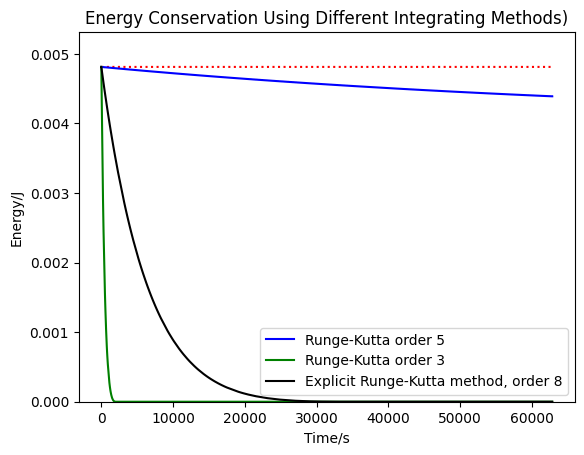

In [7]:
#Plot results
fig3, ax3 =plt.subplots()
ax3.set_title('Energy Conservation Using Different Integrating Methods)')

ax3.set_xlabel('Time/s')
ax3.set_ylabel('Energy/J')
ax3.plot(t,E_theory,color='r',linestyle=':')
ax3.set_ylim(bottom=0,top=E[0]+0.0005)

ax3.plot(t,E,color='b',label='Runge-Kutta order 5')
ax3.plot(t_RK23,E_RK23,color='g',label='Runge-Kutta order 3')
ax3.plot(t_DOP853,E_DOP853,color='k', label='Explicit Runge-Kutta method, order 8')
ax3.legend(loc='best')

fig3.show()



Surprising that the order 8 method doesn't seem to conserve energy as effectively as the order 5 method.


### Assessing the effect of Amplitude on Period


In [9]:
''' In order to find the period, integrate the equations of motion for around 10 natural periods,
Record the times that theta has a sign change (crosses theta=0), the gap between these times is half the period
Calculate the average period across the time span. Do this process for a range of theta_0 values.
'''


theta_vals=np.linspace(0,np.pi,50) #Choose an array of 50 theta_0 values between 0 and pi

t_span=(0,10*t_0)#Timespan of 10 natural periods



def find_period(t,theta):
  '''Function that takes a range of theta values and corresponding t values and returns the mean period.
  - Detect when theta changes between positive and negative, add this time to an array labelled zero_times
  - Take the difference between zero_times elements and take the mean to get the period.
  '''
  zero_times=[]

  for i in range(1,len(t)):
    if theta[i-1]*theta[i]<0:
      zero_times.append(t[i])

  periods=2*np.diff(zero_times)


  return np.mean(periods)

period_for_theta=np.zeros_like(theta_vals)
for i in range(len(period_for_theta)):

  solution=scipy.integrate.solve_ivp(
      fun=derivatives,
      t_span=t_span,
      y0=[theta_vals[i],0],
      args=(q,F)
  )

  t,theta,w = solution.t, solution.y[0], solution.y[1]
  period_for_theta[i]=find_period(t,theta)


Period at pi/2 is: 7.44s


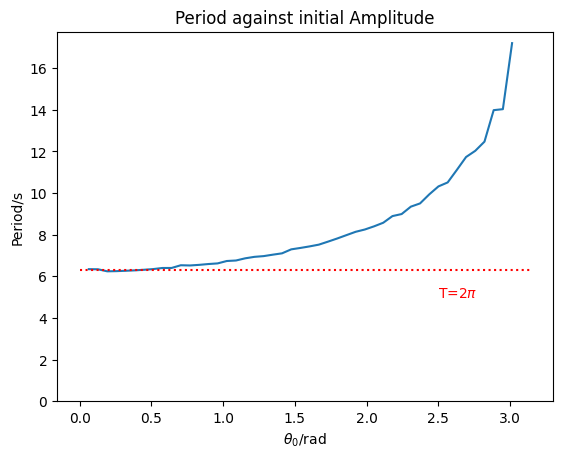

In [10]:
#Plot results
fig4,ax4 =plt.subplots()
ax4.set_xlabel(r'$\theta$$_0$/rad')
ax4.set_ylabel('Period/s')
ax4.set_title('Period against initial Amplitude')
ax4.plot(theta_vals,period_for_theta)
ax4.plot(theta_vals,2*np.pi*np.ones_like(theta_vals), linestyle=':', color='r')
ax4.text(2.5,5,r'T=2$\pi$',color='r')
ax4.set_ylim(bottom=0)
fig4.show()
print(f'Period at pi/2 is: {period_for_theta[25].round(3)}s')

## Conclusions
- Scipy.integrate.solve_ivp was used to successfully numerically integrate the equations of motion for an undamped unforced pendulum.
- For small initial angle (0.01rad) the numerical solution corresponded well to the theoretical solution given using the small angle approximation: $sin(\theta)\approx\theta$, over a range of 10-1000 periods of oscillation.
- However, the numerical solution did not conserve energy. There was an 8.781% energy decrease over 10000 periods of oscillation when using an RK45 method to integrate for $\theta$.
-Using different integration methods altered the accuracy of the numerical solution (reflected in a change in the energy loss). RK23, a 3rd order method, showed a much more significant energy loss compared to the default 5th order method. Surprisingly, DOP853, an 8th order Runge-Kutta method, seemed to show poorer accuracy than the default method, this may be because the time steps were chosen differently for the two methods.
- The period of oscillations was plotted as a function of the intial angle for a range of angles from ($0,\pi$).
-When the initial angle was small, the period was approximately equal to the natural period of $2\pi$;however, as the initial angle increased the period also increased.
- The period at $\theta=\frac{\pi}{2}$ was 7.44s.

# Core Task 2:
- Plot behaviour for damped and driven scenarios
- Examine how driving force affects period

In [11]:
'''Plotting behaviour for different levels of damping
- In small angle limit, theory implies that critical damping occurs at q=2
'''


theta_0= np.pi/2

t_span= (0,10*t_0)

#To make things less repetitive, define a function which returns, t,theta and dtheta/dt for given inputs

def give_solution(q,F,theta_0):
  solution=scipy.integrate.solve_ivp(
      fun=derivatives,
      t_span=t_span,
      y0=[theta_0,0],
      args=(q,F)
  )


  return (solution.t,solution.y[0],solution.y[1])


q_vals=(0.5,1,2,5,10) #Range of damping to investigate

damped_solutions={} #Dictionary to store the data

for i in range(len(q_vals)):
  #add results to a dictionary
  damped_solutions[f'q={q_vals[i]}']= give_solution(q_vals[i],0,theta_0)




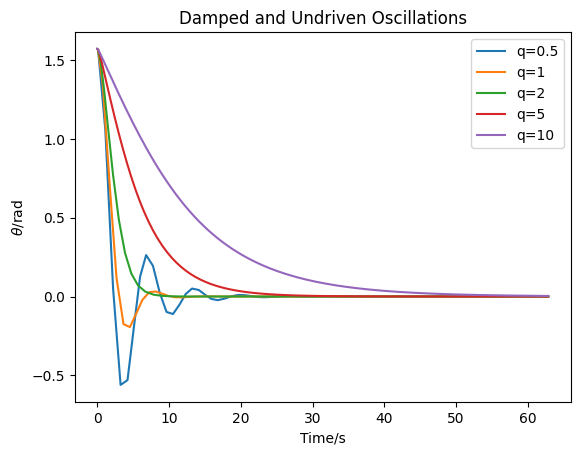

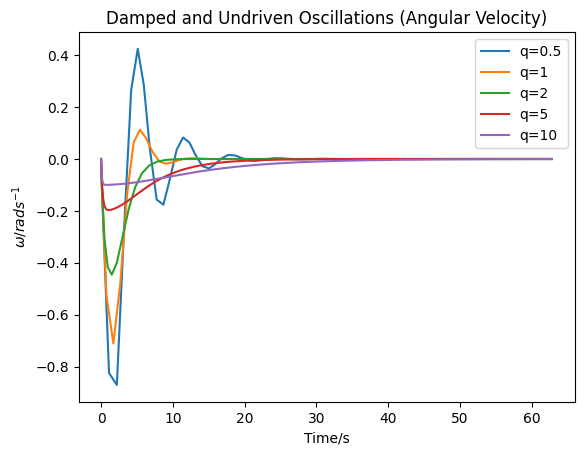

In [12]:
#Plot results
fig5,ax5 =plt.subplots()
ax5.set_title('Damped and Undriven Oscillations')

ax5.set_xlabel('Time/s')
ax5.set_ylabel(r'$\theta$/rad')

for key in damped_solutions:
  ax5.plot(damped_solutions[key][0],damped_solutions[key][1], label=key)

ax5.legend(loc='best')


fig5.show()

fig6,ax6 =plt.subplots()
ax6.set_title('Damped and Undriven Oscillations (Angular Velocity)')

ax6.set_xlabel('Time/s')
ax6.set_ylabel(r'$\omega$/$rads^{-1}$')

for key in damped_solutions:
  ax6.plot(damped_solutions[key][0],damped_solutions[key][2], label=key)

ax6.legend(loc='best')


fig6.show()

As expected, q<1 corresponds to underdamped (oscillating) solutions, q=2 gives a critically damped solution and q>2 gives over damped solutions.

In [13]:
#Now investigate a range of F values with q fixed at 0.5

theta_0= np.pi/2

t_span= (0,20*t_0)



forced_solutions={} #Dictionary to store the data

F_vals=(0.1,0.5, 1.2, 1.44, 1.465)#List of F values to investigate

for i in range(len(F_vals)):
  #add results to a dictionary
  forced_solutions[f'F={F_vals[i]}']= give_solution(0.5,F_vals[i],theta_0)


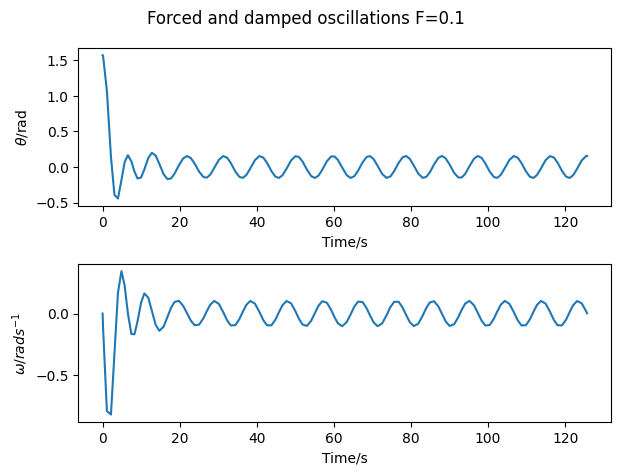

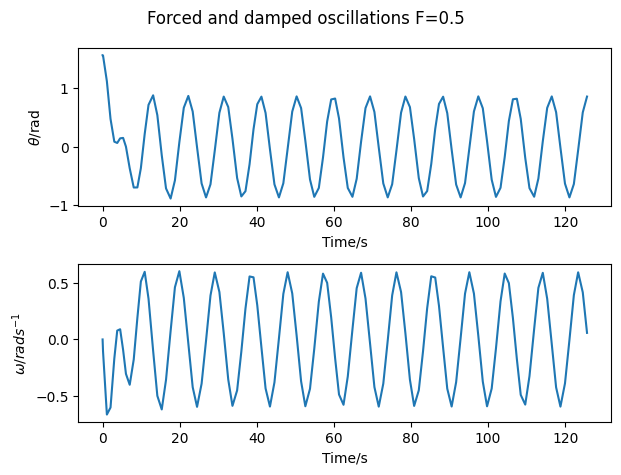

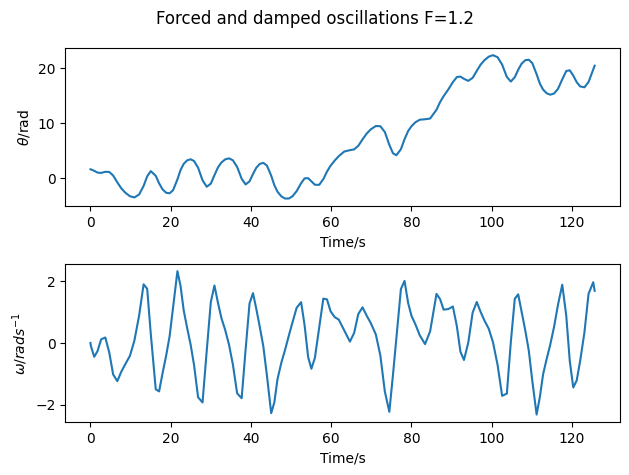

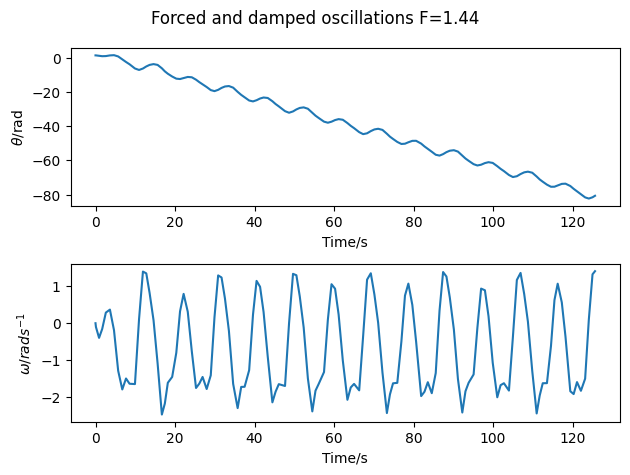

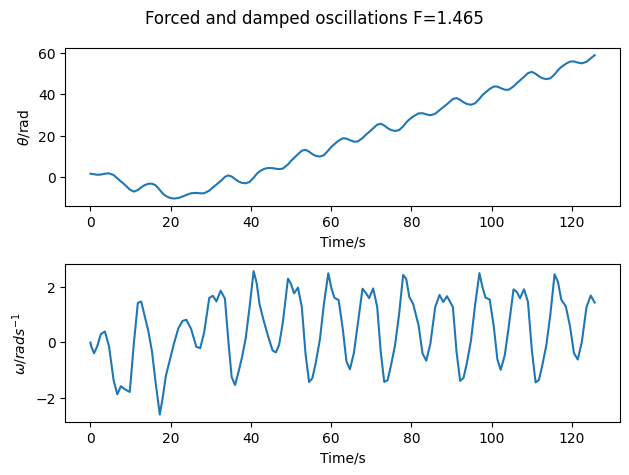

In [14]:
#Plot in separate graphs


for i,key in enumerate(forced_solutions):
  plt.subplot(2,1,1)
  plt.xlabel('Time/s')
  plt.ylabel(r'$\theta$/rad')
  plt.plot(forced_solutions[key][0],forced_solutions[key][1])

  plt.subplot(2,1,2)
  plt.xlabel('Time/s')
  plt.ylabel(r'$\omega$/$rads^{-1}$')
  plt.plot(forced_solutions[key][0],forced_solutions[key][2])

  plt.suptitle(f'Forced and damped oscillations {key}')
  plt.tight_layout()


  plt.show()




When the forcing is large enough, the pendulum undergoes complete rotations, this can be seen on the graphs as $|\theta|$ becomes larger than $\pi$.
Period must be determined by noting stationary points, i.e. zeros in the angular velocity.

In [15]:
'''Find period of oscillation at different forcing
- Can re-use old find_period function but must consider angular velocity instead
- Would expect the period to eventually match that of the driving frequency once the initial transient behaviour dies away
'''

print(f'Expected period (driving force) is {round((3*np.pi),3)}')
print(f'(When t_span={t_span})')
for key in forced_solutions:

  print(f'Average period for {key} is: {find_period(forced_solutions[key][0],forced_solutions[key][2]).round(3)}')




Expected period (driving force) is 9.425
(When t_span=(0, 125.66370614359172))
Average period for F=0.1 is: 9.012
Average period for F=0.5 is: 9.112
Average period for F=1.2 is: 10.037
Average period for F=1.44 is: 9.346
Average period for F=1.465 is: 9.221


## Conclusions
- For unforced and damped pendulum, the numerically integrated solution exhibits the expected behaviour: underdamping for q<2 and overdamping when q>2
- When forcing is applied to the damped pendulum, there is initial transient behaviour; however, over time the period approaches that of the driving force.

# Supplementary Task 1
- Investigating sensitivity to intiial conditions

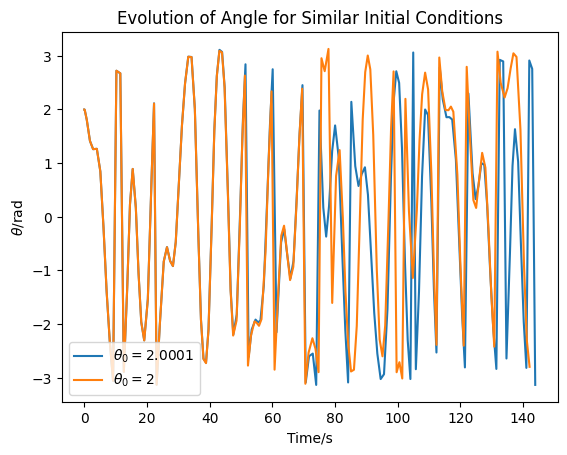

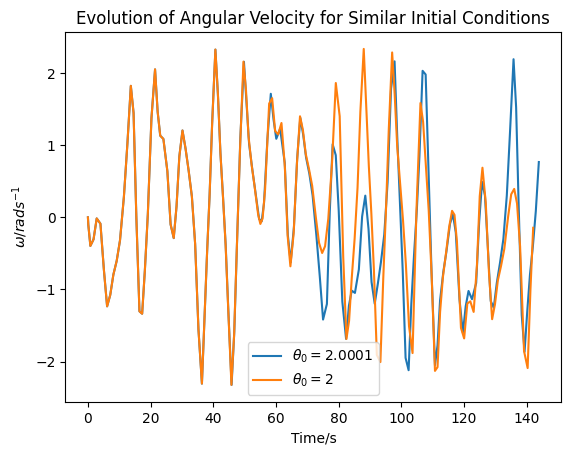

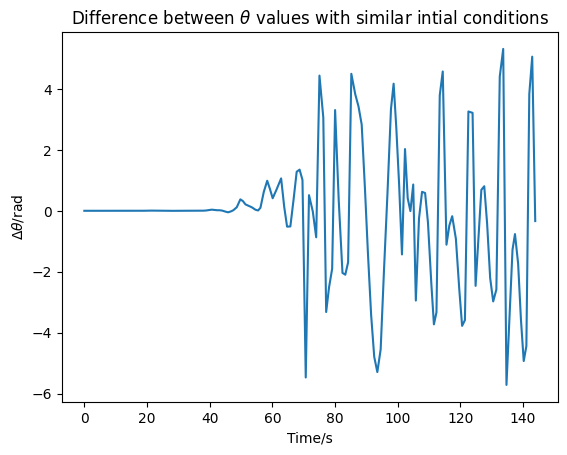

In [16]:


comparing_solutions={} #Dictionary to store the data
t_span=(0,1000*t_0)

datalimit=150 #A variable to choose how much time is shown on each plot

comparing_solutions[r'$\theta_0=2.0001$']= give_solution(0.5,1.2,2.0001)
comparing_solutions[r'$\theta_0=2$']= give_solution(0.5,1.2,2)

'''Define a function that uses the modulo operator on the theta values to keep them within range -pi<theta<pi for easier comparison
This accounts for full rotations of the pendulum'''

def within_bounds(theta):
  return ((theta+np.pi)% (2 * np.pi)) - np.pi



for key in comparing_solutions:
  plt.plot(comparing_solutions[key][0][0:datalimit], within_bounds(comparing_solutions[key][1][0:datalimit]),label=key)

plt.xlabel('Time/s')
plt.ylabel(r'$\theta$/rad')
plt.title('Evolution of Angle for Similar Initial Conditions')


plt.legend()
plt.show()

for key in comparing_solutions:
  plt.plot(comparing_solutions[key][0][0:datalimit], comparing_solutions[key][2][0:datalimit],label=key)

plt.xlabel('Time/s')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.title('Evolution of Angular Velocity for Similar Initial Conditions')
plt.legend()
plt.show()

'''Plot a graph to show the difference between the two theta values as a function of time'''

difference=within_bounds(comparing_solutions[r'$\theta_0=2.0001$'][1])-within_bounds(comparing_solutions[r'$\theta_0=2$'][1])
plt.plot(comparing_solutions[r'$\theta_0=2.0001$'][0][0:datalimit],difference[0:datalimit])
plt.xlabel('Time/s')
plt.ylabel(r'$\Delta\theta$/rad')
plt.title(r'Difference between $\theta$ values with similar intial conditions')
plt.show()



## Conclusions
- Initially the two solutions are very similar.
- After around 45 seconds the angle and angular velocity begin to diverge.
- Beyond this point the two solutions seem to evolve completely differently and unrelated to each other.
- The pendulum seems to be a chaotic system (small changes in initial conditions can lead to completely different dynamics).

# Supplementary Task 2
-Investigating plots of angle vs angular speed

### Small Initial Angle Regime
- For small angles the potential energy: $mgl(1-cos(\theta))$ is approximately equal to $\frac{1}{2}mgl\theta^2$
- The kinetic energy is equal to $\frac{1}{2}ml^2\omega^2$
- Since $g=l$ in this model, total Energy is given by:
  $E = \frac{1}{2}mg^2(\theta^2+\omega^2)$
- Therefore, on a graph of $\omega$ against $\theta$, the distance from the origin to a point on the graph is proportional to the square root of the energy at that time.

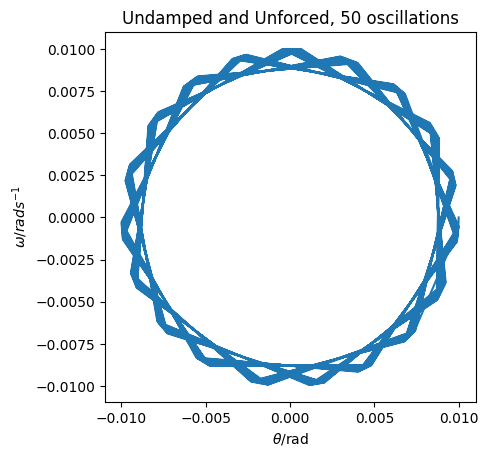

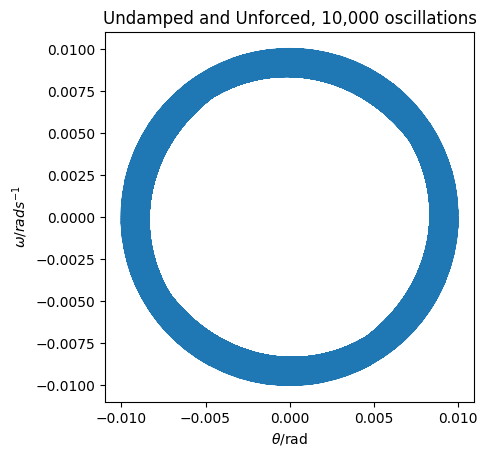

In [17]:
#Plotting small initial angle solution, no damping no forcing

t_span=(0,50*t_0)
plt.plot(give_solution(0,0,0.01)[1],give_solution(0,0,0.01)[2])
plt.title('Undamped and Unforced, 50 oscillations')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()

t_span=(0,10000*t_0)
plt.plot(give_solution(0,0,0.01)[1],give_solution(0,0,0.01)[2])
plt.title('Undamped and Unforced, 10,000 oscillations')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()




- In an undamped and unforced system, total energy should remain constant, therefore the expected result is a smooth circle in the $\theta,\omega$ plane.
- For the 50 oscillation result, the lack of smoothness can be attributed to
the finite sized jumps in time between calculating values.
- For a larger number of oscillations, it is clear that the radius of the circle is gradually decreasing (the thickness of the circle increases with the time span integrated over), corresponding to a loss of energy in the system.
- This matches the results from core task 1 which shows that the energy of the undamped unforced pendulum decreases by around 8.8% over 10,000 periods of oscillation due to accumulating error in the numerical integration


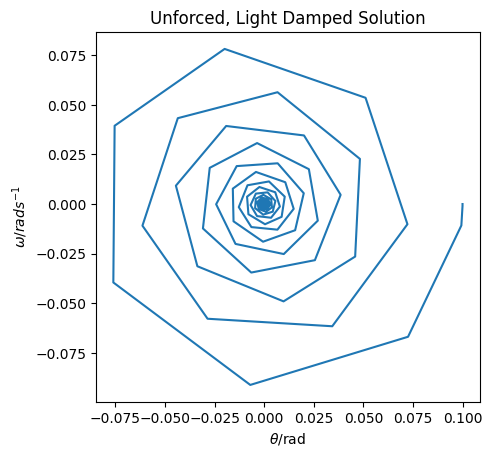

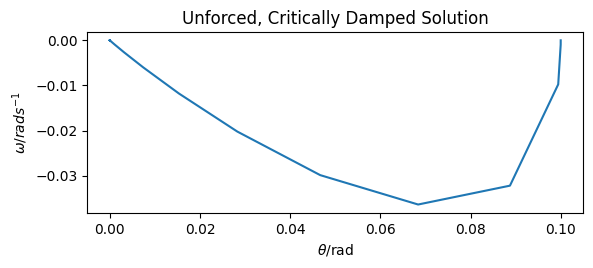

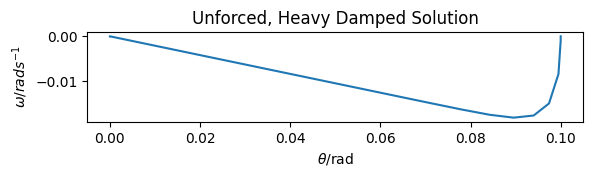

In [18]:
#Plotting small initial angle solution, no forcing different damping


t_span=(0,50*t_0)

plt.plot(give_solution(0.1,0,0.1)[1],give_solution(0.1,0,0.1)[2])
plt.title('Unforced, Light Damped Solution')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()


plt.plot(give_solution(2,0,0.1)[1],give_solution(2,0,0.1)[2])
plt.title('Unforced, Critically Damped Solution')

plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')
plt.show()

plt.plot(give_solution(5,0,0.1)[1],give_solution(5,0,0.1)[2])
plt.title('Unforced, Heavy Damped Solution')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()

- As expected, introducing damping causes the energy of the system to decrease to 0
- Most easily observed in the light damping case, where the spiral towards (0,0) corresponds to energy loss due to the damping

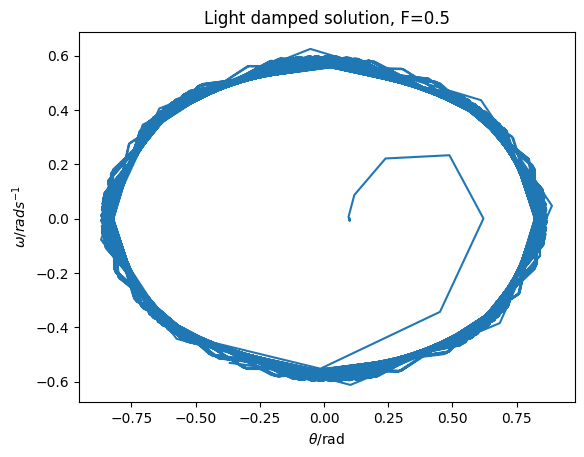

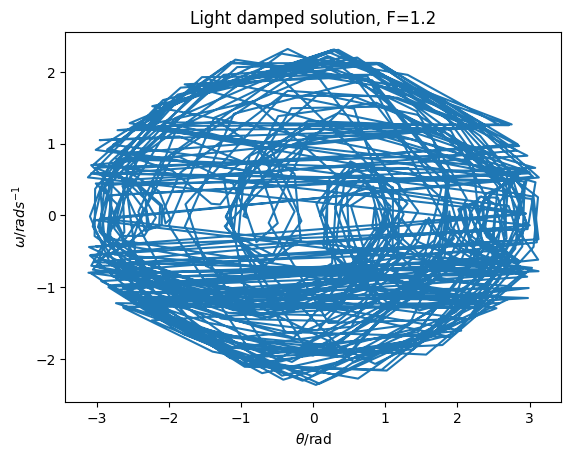

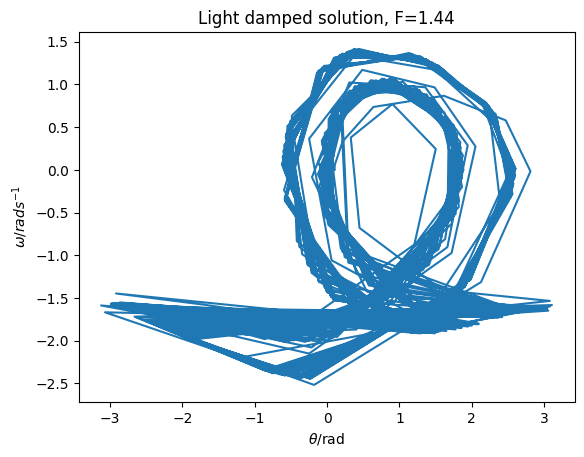

In [19]:
#Plotting small initial angle solution, fixed damping, different forcing


t_span=(0,100*t_0)

plt.plot(give_solution(0.5,0.5,0.1)[1],give_solution(0.5,0.5,0.1)[2])
plt.title('Light damped solution, F=0.5')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')


plt.show()


plt.plot(within_bounds(give_solution(0.5,1.2,0.1)[1]),give_solution(0.5,1.2,0.1)[2])
plt.title('Light damped solution, F=1.2')

plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')

plt.show()

plt.plot(within_bounds(give_solution(0.5,1.44,0.1)[1]),give_solution(0.5,1.44,0.1)[2])
plt.title('Light damped solution, F=1.44')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')


plt.show()

- For smaller forcing, the pendulum doesn't ever swing all the way round and eventually reaches a stable solution where the power provided by the forcing matches the power lost by the damping, therefore energy remains roughly constant giving an approximately circular solution.
- For larger forcing, the pendulum can perform full rotations and this gives rise to much more chaotic solutions

### Larger initial angles
- Repeating previous plots but with a larger inital angle
- Results should now deviate more significantly from the simpler theoretical predictions

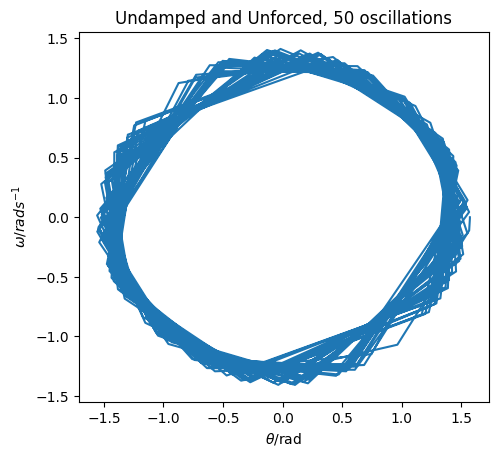

In [ ]:
#Plotting no damping no forcing

t_span=(0,50*t_0)
plt.plot(give_solution(0,0,np.pi/2)[1],give_solution(0,0,np.pi/2)[2])
plt.title('Undamped and Unforced, 50 oscillations')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()

t_span=(0,10000*t_0)
plt.plot(give_solution(0,0,np.pi/2)[1],give_solution(0,0,np.pi/2)[2])
plt.title('Undamped and Unforced, 10,000 oscillations')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()




- For a larger initial angle ($\theta_0=\frac{\pi}{2}$) the solutions are no longer perfectly circular
- The energy loss from the numerical integration also seems to be more significant (size of 'circle' decreases more for the same amount of oscillatiosn).

In [ ]:
#Plotting larger initial angle solution, no forcing different damping


t_span=(0,50*t_0)

plt.plot(give_solution(0.1,0,np.pi/2)[1],give_solution(0.1,0,np.pi/2)[2])
plt.title('Unforced, Light Damped Solution')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()


plt.plot(give_solution(2,0,np.pi/2)[1],give_solution(2,0,np.pi/2)[2])
plt.title('Unforced, Critically Damped Solution')

plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')
plt.show()

plt.plot(give_solution(5,0,np.pi/2)[1],give_solution(5,0,np.pi/2)[2])
plt.title('Unforced, Heavy Damped Solution')
plt.ylabel(r'$\omega$/$rads^{-1}$')
plt.xlabel(r'$\theta$/rad')
plt.gca().set_aspect('equal')

plt.show()

- The general form of these graphs doesn't seem to be particularly affected by a larger initial angle

## Conclusion:
- Plots of $\theta$ against $\omega$ are relatively regular provided the damping and forcing is such that the pendulum doesn't complete any full rotations:
  - Unforced and undamped solutions roughly trace out circles (as energy remains approx. constant)
  - Unforced and damped solutions tend towards (0,0), underdamping leads to spiralling behaviour.
  - Damped and forced pendulums eventually stabilise to an approximately circular solution where energy lost to damping matches energy gained from forcing.
-  Over a large time frame (1000s of oscillations), inaccuracies due to numerical integration using solve_ivp leads to a noticeable energy loss from the system, consequently for large time frames, circular solutions begin to spiral slowly towards (0,0).

- Larger intial angles cause behaviour to deviate from the simple small-angle theoretical approximations, patterns in the $\omega,\theta$ plane become less circular.
- When the forcing and damping is such that the pendulum can undergo complete rotations, the behaviour seems to be chaotic and gives highly irregular solutions.